# Module 1 Exercise - Answer (Fashion MNIST)
Train your own model and convert it to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [0]:
!pip3 install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 368.0MB 65kB/s 
     |████████████████████████████████| 3.2MB 28.3MB/s 
     |████████████████████████████████| 450kB 39.8MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from google.colab import files


print(tf.__version__)

2.0.0-dev20190628


# Download Fashion MNIST Dataset

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

W0701 11:01:27.036766 139937208235904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [0]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [0]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0
  return image, label

In [0]:
BATCH_SIZE = 32

## Create a Dataset from images and labels

In [0]:
train_batches = train_examples.shuffle(num_examples//4).map(format_example).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.shuffle(num_examples//4).map(format_example).batch(BATCH_SIZE)
test_batches = test_examples.map(format_example).batch(1)

# Building the model

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Train

In [0]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

# Exporting to TFLite

In [0]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

W0701 11:05:28.637118 139937208235904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1775: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

In [0]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [0]:
tflite_model_file = pathlib.Path('/content/model.tflite')
tflite_model_file.write_bytes(tflite_model)

356880

# Test the model with TFLite interpreter 

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [0]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

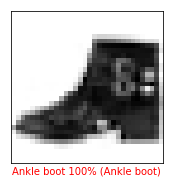

In [0]:
#@title Visualize the outputs { run: "auto" }
index = 49 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()

# Download TFLite model and assets

In [0]:
files.download(tflite_model_file)
files.download('labels.txt')

# Prepare the test images for download (Optional)

In [0]:
!mkdir -p test_images

In [0]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [0]:
!ls test_images

In [0]:
!zip -qq fmnist_test_images.zip -r test_images/

In [0]:
files.download('fmnist_test_images.zip')